# Lab 5 - Using link functions to create generalized linear models

We consider the dataset from the lecture considering Airline accidents and deaths.
Now the dataset is provided in ```Airline_data.csv``` file and you can create your own model. This time you dont get a jupyter notebook to fill so create your own. 

During the lecture we have tried Poisson models with varying degrees of success. Our considered models were (assuming $y_i$ is the number of accidents in given year):
- $y_i\sim\mathrm{Poisson}(\lambda)$ that is one fixed $\lambda$ for all years i.e. number of accidents is random independent on year where it happens
-  $y_i\sim\mathrm{Poisson}(\theta n_i)$ where $n_i$ is the ammount of miles flown that year. 

We will now try to improve upon those models using new structures and parameters. Lets add an additional mean ammount of accidents i.e model with intercept $\lambda_i=\alpha+\theta n_i$. This might be problematic, as coefficient $\lambda$ has to be positive, without appropriate carefulness it could create errors in sampling. Typical approach is to use a *link function*, i.e. function that would transform domain of parameter to one that is applicable. For Poisson distributions it is popular to use logarithm:

$$\log \lambda_i=\alpha+\theta n_i$$

which translates to the following sampling statement

$$ y_i\sim\mathrm{Poisson}(\underbrace{\exp(\alpha+\theta n_i)}_{\lambda_i})$$

Create such model and perform prior predictive analysis to choose priors. 

**Important** chose priors wisely, as exponential function can become quite large and return errors in sampling when it becomes too big. Perhaps before sampling of Poisson try to find what kind of values for $\lambda_i$ come from priors. 

After testing priors fit the model to data and evaluate its efficiency by by posterior predictive distribution and comparing histograms of accidents for entire period and for each year.

Try to improve the model by replacing single intercept $\alpha$ with individual intercepts of $\alpha_i$ for each year. It can be easily done, by declaring $\alpha$ as an array of appropriate dimension. Then only one prior is needed as it will be used for all the elements of the array.

Again perform the prior predictive distribution analysis to select prior parameters, fit the model and analyze its output. 


In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
airline_df = pd.read_csv("Airline_data.csv")
airline_df["Flown length [100 bln miles]"] = airline_df["Miles flown [100 mln miles]"] / 1000.0
airline_df.head()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles],Flown length [100 bln miles]
0,1976,24,734,3863.0,3.863
1,1977,25,516,4300.0,4.300
2,1978,31,754,5027.0,5.027
3,1979,31,877,5481.0,5.481
4,1980,22,814,5814.0,5.814


In [3]:
airline_df.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles],Flown length [100 bln miles]
count,10.00000,10.000000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000,5.715800
std,3.02765,4.709329,252.389228,1117.767795,1.117768
min,1976.00000,16.000000,223.000000,3863.000000,3.863000
25%,1978.25000,21.250000,570.500000,5140.500000,5.140500
50%,1980.50000,23.000000,759.000000,5845.500000,5.845500
75%,1982.75000,25.750000,812.750000,6175.500000,6.175500
max,1985.00000,31.000000,1066.000000,7433.000000,7.433000


### Prior predictive analysis

In [4]:
model_ppc=CmdStanModel(stan_file='prior.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,
                     refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [5]:
sim_df = sim.draws_pd()
sim_df.describe()

,lp__,accept_stat__,alpha,theta,ni,lambda,yi
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,2.253922,0.209395,5.439889,39.081946,38.962000
std,0.0,0.0,0.714376,0.011913,0.885030,32.016166,32.989102
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,1.768158,0.202993,4.876725,17.754450,18.000000
50%,0.0,0.0,2.259745,0.209829,5.429630,29.921600,30.000000
75%,0.0,0.0,2.740365,0.216576,6.038175,50.202725,51.000000
max,0.0,0.0,4.416790,0.239458,8.077610,292.566000,300.000000


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'ni'}>,
        <AxesSubplot:title={'center':'lambda'}>],
       [<AxesSubplot:title={'center':'yi'}>, <AxesSubplot:>]],
      dtype=object)

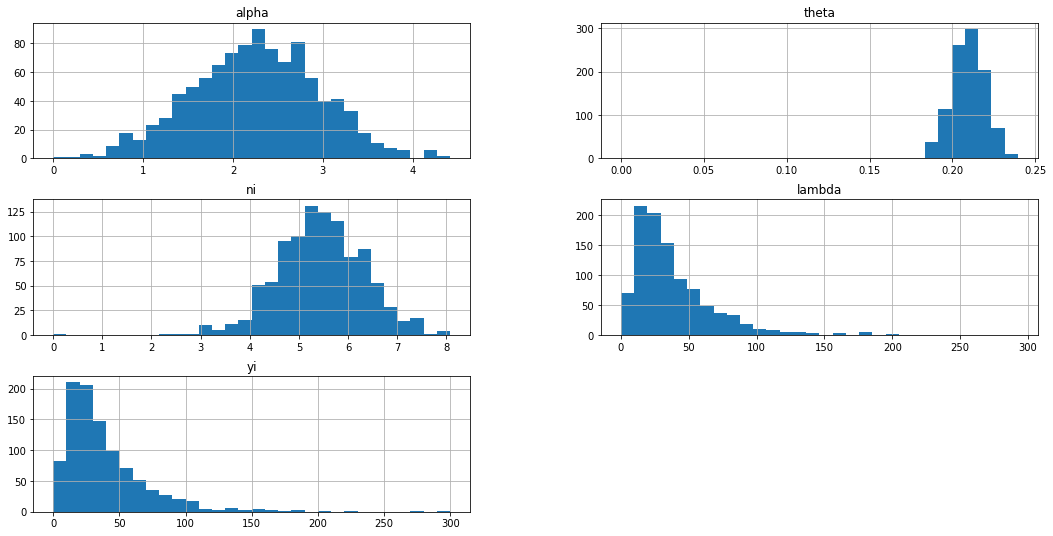

In [6]:
sim_df.hist(column=['alpha', 'theta', 'ni', 'lambda', 'yi'], figsize=(18, 9), bins=30)

### Posterior predictive distribution (single intercept $\alpha$)

In [7]:
fit_model=CmdStanModel(stan_file='fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [8]:
data_fit = dict(N=len(airline_df),
                n = airline_df["Flown length [100 bln miles]"].values,
                y = airline_df["Fatal accidents"].values)

fit=fit_model.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [9]:
fit_df = fit.draws_pd()
fit_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambda[1],...,y_pred[1],y_pred[2],y_pred[3],y_pred[4],y_pred[5],y_pred[6],y_pred[7],y_pred[8],y_pred[9],y_pred[10]
0,500.599,1.000000,0.470001,1.0,1.0,0.0,-499.534,1.88833,0.189306,13.7305,...,12.0,24.0,23.0,15.0,24.0,20.0,18.0,23.0,16.0,27.0
1,503.676,0.982399,0.470001,2.0,7.0,0.0,-499.176,2.12239,0.198022,17.9457,...,16.0,20.0,19.0,25.0,31.0,37.0,34.0,27.0,39.0,49.0
2,504.493,1.000000,0.470001,2.0,3.0,0.0,-503.714,2.07509,0.191133,16.6672,...,14.0,23.0,23.0,20.0,19.0,23.0,23.0,24.0,30.0,26.0
3,504.442,0.994866,0.470001,3.0,7.0,0.0,-504.072,1.92825,0.212963,15.6572,...,16.0,18.0,19.0,32.0,18.0,25.0,26.0,26.0,37.0,28.0
4,504.889,0.998816,0.470001,3.0,7.0,0.0,-504.371,2.04607,0.200122,16.7624,...,16.0,21.0,17.0,31.0,26.0,25.0,21.0,26.0,44.0,47.0


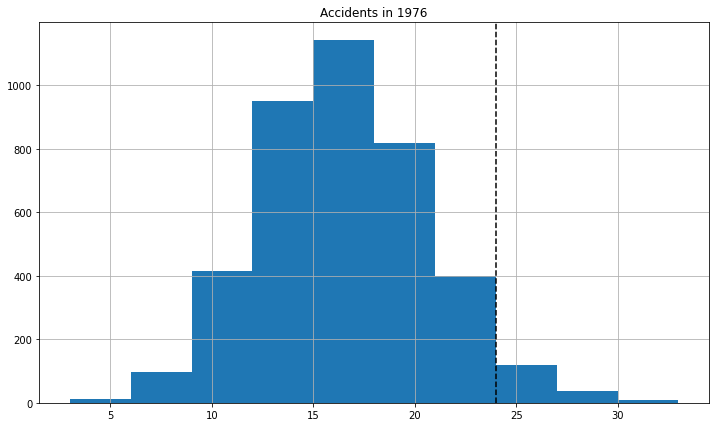

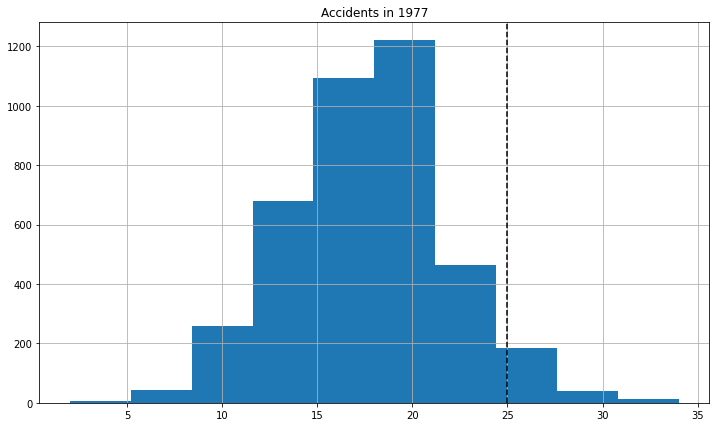

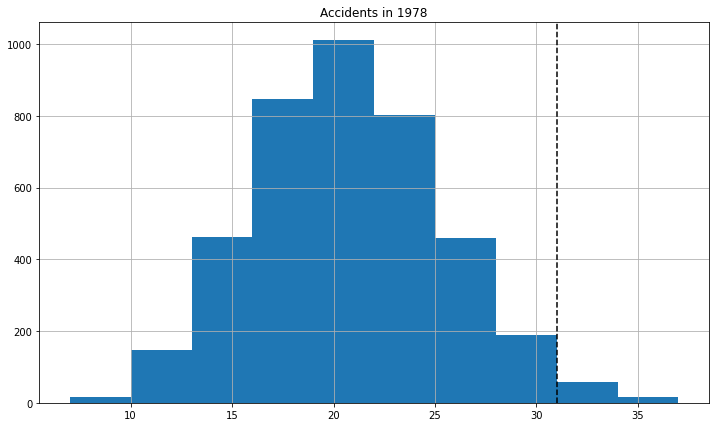

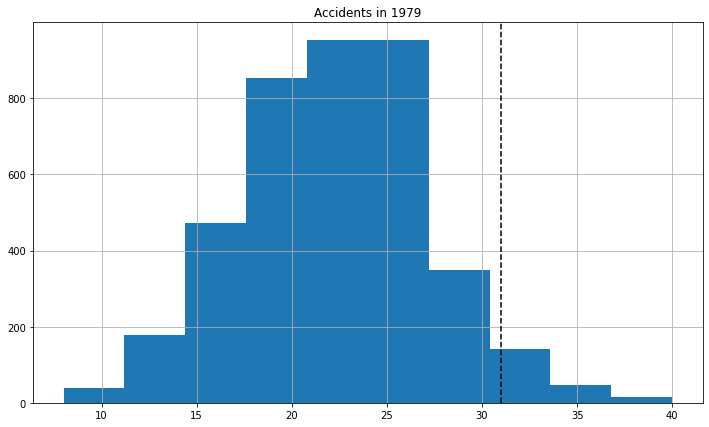

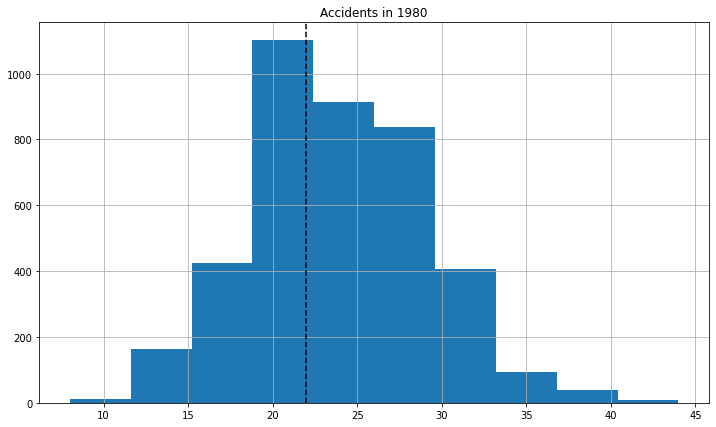

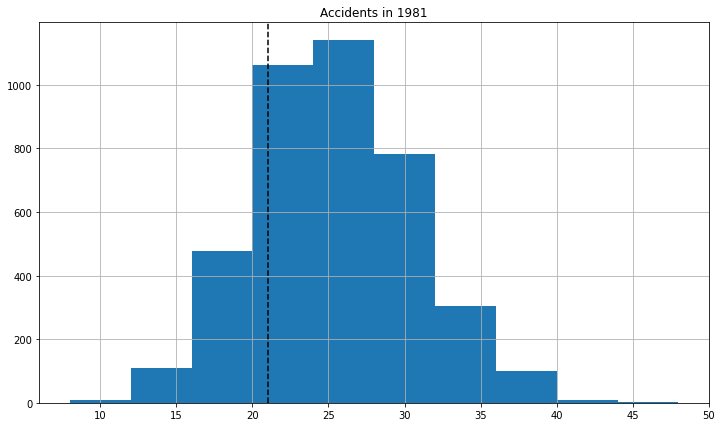

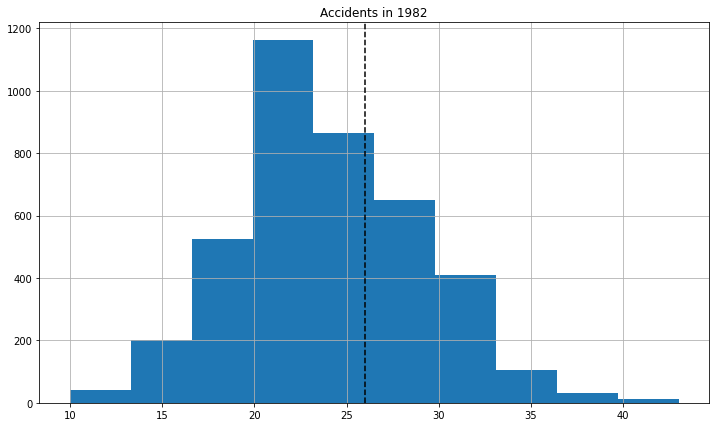

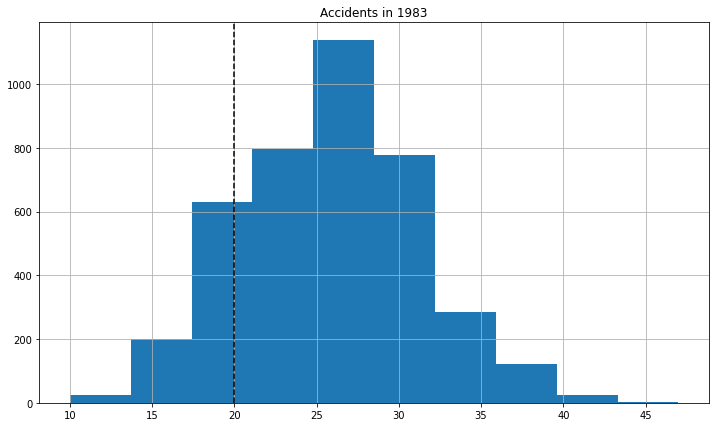

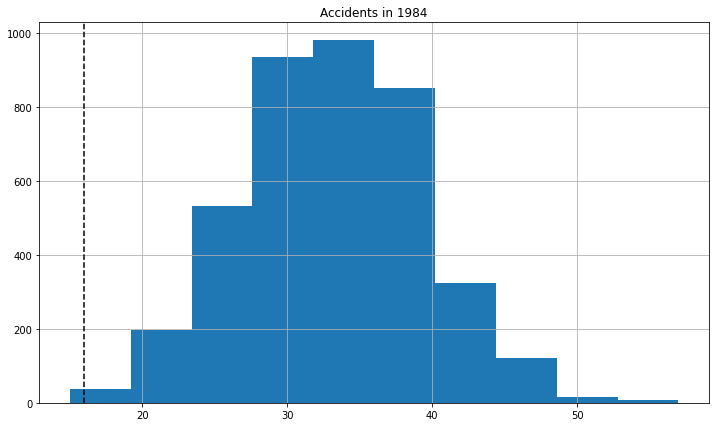

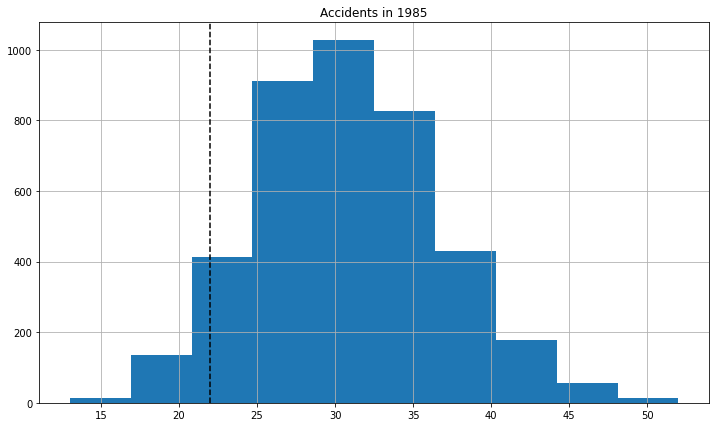

In [10]:
for i, year in enumerate(airline_df['Year'].values, start=1):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.hist(fit_df[f'y_pred[{i}]'])
    ax.axvline(x=data_fit['y'][i-1], color='black', linestyle="--")
    ax.set_title("Accidents in " + str(year))
    ax.grid()

### Prior predictive analysis (individual intercepts of $\alpha_i$ for each year)

In [11]:
fit_model2=CmdStanModel(stan_file='fit2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [12]:
data_fit2 = dict(N=len(airline_df),
                n = airline_df["Flown length [100 bln miles]"].values,
                y = airline_df["Fatal accidents"].values)

fit2=fit_model2.sample(data=data_fit2,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [13]:
fit_df2 = fit2.draws_pd()
fit_df2.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,y_pred[1],y_pred[2],y_pred[3],y_pred[4],y_pred[5],y_pred[6],y_pred[7],y_pred[8],y_pred[9],y_pred[10]
0,514.465,0.845871,0.584976,3.0,7.0,0.0,-506.555,2.30192,2.25839,2.42085,...,27.0,21.0,25.0,34.0,21.0,9.0,20.0,17.0,17.0,18.0
1,515.618,0.925569,0.584976,3.0,7.0,0.0,-510.703,2.30371,2.37361,2.41441,...,25.0,30.0,32.0,30.0,20.0,19.0,26.0,28.0,18.0,30.0
2,512.074,0.723991,0.584976,3.0,7.0,0.0,-507.696,2.23489,2.41560,2.30009,...,17.0,31.0,24.0,47.0,17.0,16.0,25.0,23.0,21.0,18.0
3,511.162,0.900118,0.584976,3.0,7.0,0.0,-504.406,2.51839,2.27899,2.52375,...,35.0,25.0,40.0,24.0,17.0,30.0,24.0,20.0,13.0,34.0
4,513.462,0.980638,0.584976,3.0,7.0,0.0,-508.073,2.19651,2.45807,2.46759,...,22.0,30.0,25.0,42.0,30.0,5.0,27.0,26.0,15.0,30.0


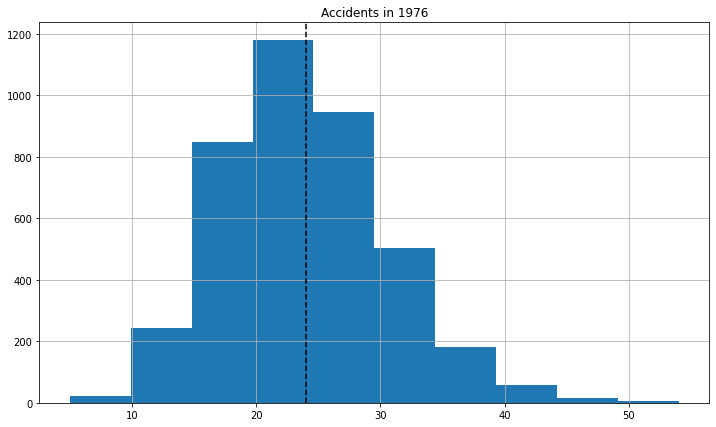

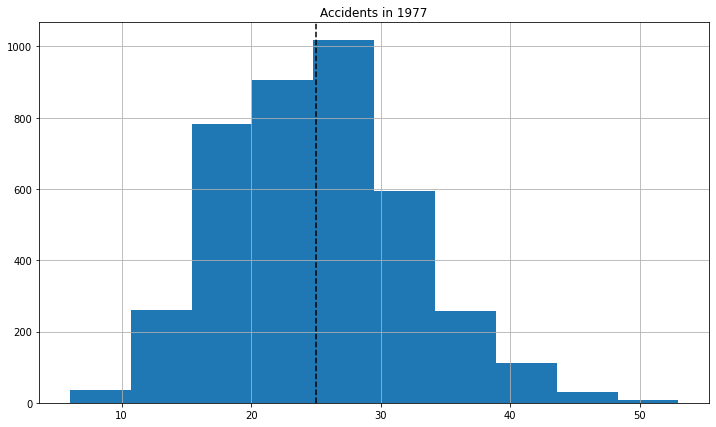

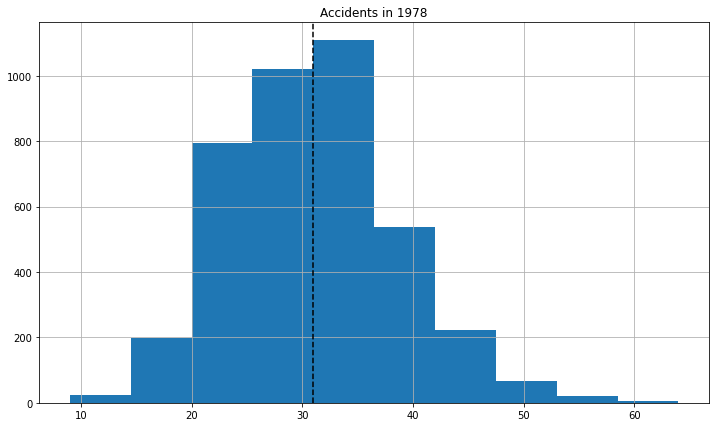

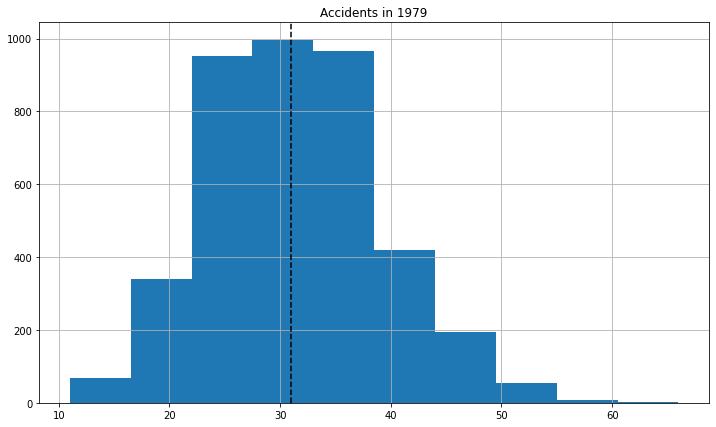

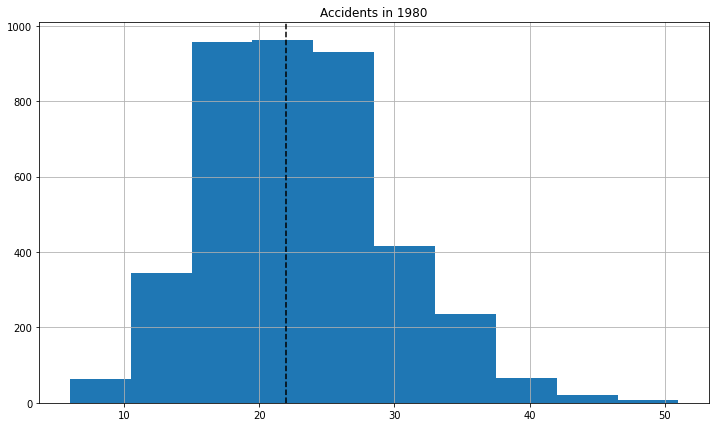

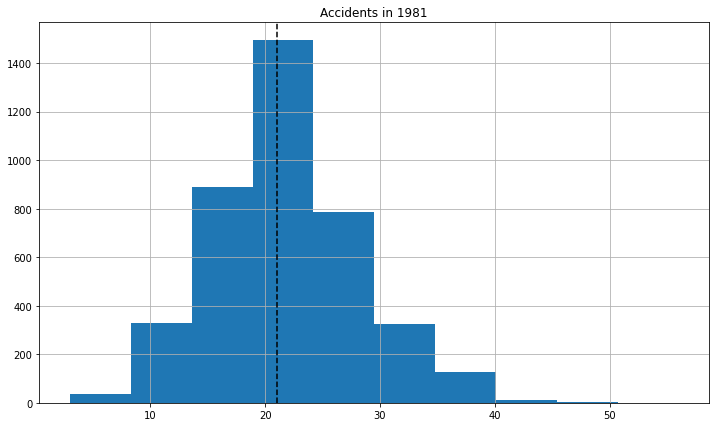

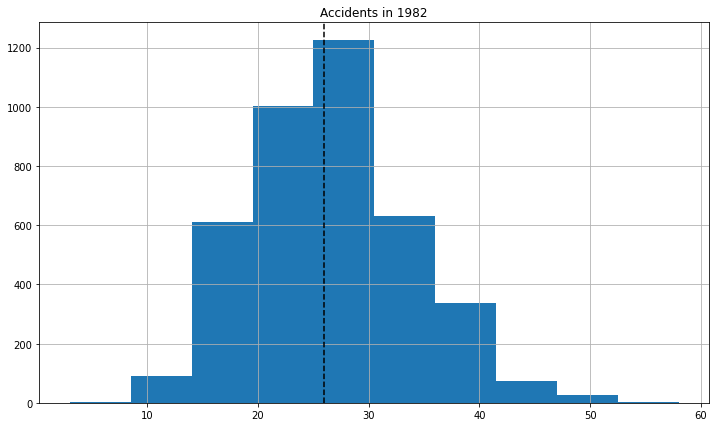

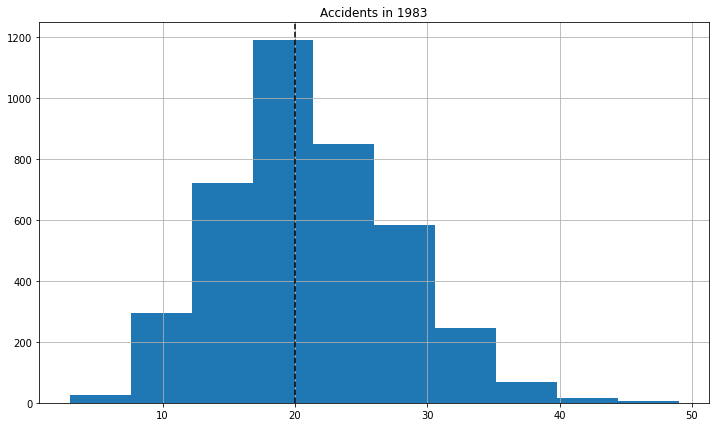

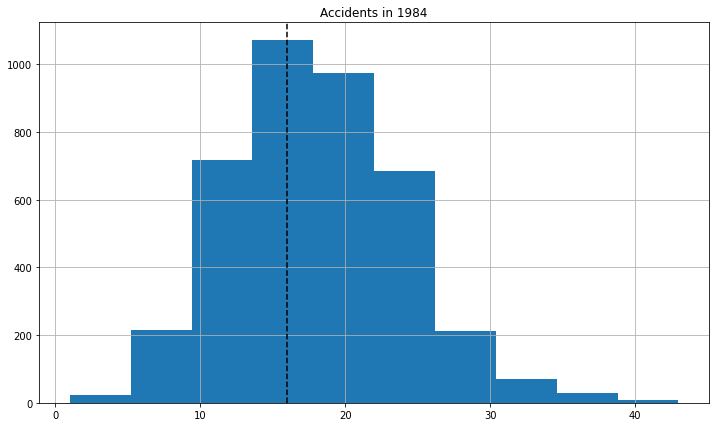

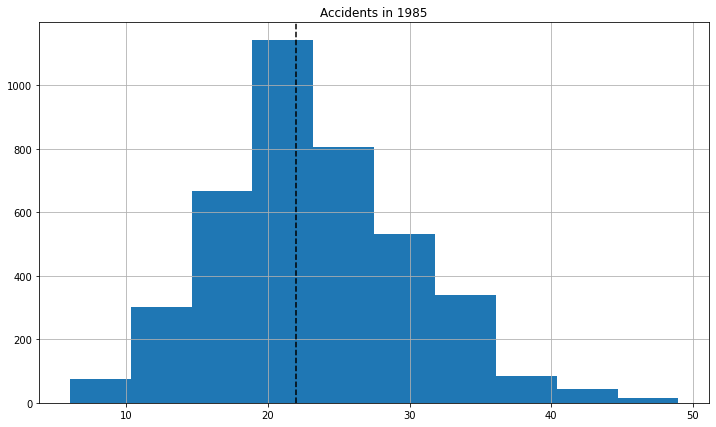

In [14]:
for i, year in enumerate(airline_df['Year'].values, start=1):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.hist(fit_df2[f'y_pred[{i}]'])
    ax.axvline(x=data_fit['y'][i-1], color='black', linestyle="--")
    ax.set_title("Accidents in " + str(year))
    ax.grid()